# Run level 2A and 2B pipelines on LRS-SLITLESS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) Decemeber 5th 2017

This notebook demonstrates the execution of the level 2A, 2B and 3 pipelines for LRS-SLITLESS data in Python using the jwst step classes.

Documentation on each pipeline step can be found here:

http://ssb.stsci.edu/doc/jwst_dev/

The file used in this notebook is a MIRISim simulation (no dithering for LRS-SLITLESS) of a point source with a blackbody spectrum plus emission lines, with a variable absorption component. Because LRS-SLITLESS is TSO mode, there are 3 exposures of 20 integrations, with 20 groups per integration. The data arrays of each exposure are the same, i.e., they are clones only separated in time.

Note that, because of the current uncertainty in some metadata in slitless prism subarray data, we must manually set the array name to what the pipeline expects, ie.:

dm.meta.subarray.name = 'SUBPRISM'

which is done below prior to the Detector1Pipeline call.

LRS-SLITLESS is intended for TSOs, therefore, unlike LRS-SLIT, MRS and IMA, we want to get output products per integration rather than per exposure. This is facilitated through the 'rateints' product of the Detector1Pipeline (i.e., a slope-per-integration product). This product is then put through the Spec2Pipeline where calibrations are applied to the slope image of each integration where appropriate, yielding a 'calints' product. The Spec2Pipeline will also output the 'x1dints' file which contains a spectrum extract from each integration. In level 3, the 'calints' products are combined into a single product and white-light photometry is performed to show the variation in integrated flux during the three exposures.

The following steps are applied:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps (Spec2Pipeline), including spectral extraction from each integration

- combination of multiple exposure products and white-light photometry (Tso3Pipeline)

- manual conversion of extracted spectra to Jy using SRF


#### NB: The final extracted spectra will not have the correct shape. This is due to ongoing uncertainty regarding the correct reference position for the slitless prism subarray.

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. 
input_dir = 'LRS-SLITLESS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'det*.fits'))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
        
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Type\t\t\t Filter\t subAr\t\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Type			 Filter	 subAr		 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIR_LRS-SLITLESS	 P750L	 SLITLESSPRISM	 20	 20	 FAST	 63.6



Filename: LRS-SLITLESS_demo_data/det_image_1_MIRIMAGE_P750Lexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     102   ()      
  1  SCI           1 ImageHDU        62   (72, 416, 20, 20)   float32   
  2  PIXELDQ       1 ImageHDU        11   (72, 416)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (72, 416, 20, 20)   uint8   
  4  ERR           1 ImageHDU        11   (72, 416, 20, 20)   float32   
  5  REFOUT        1 ImageHDU        12   (18, 416, 20, 20)   float32   
  6  ASDF          1 ImageHDU         7   (18879,)   uint8   
  7  PIXELDQ_DEF    1 BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   


#### show the last frame of each integration in the first exposure

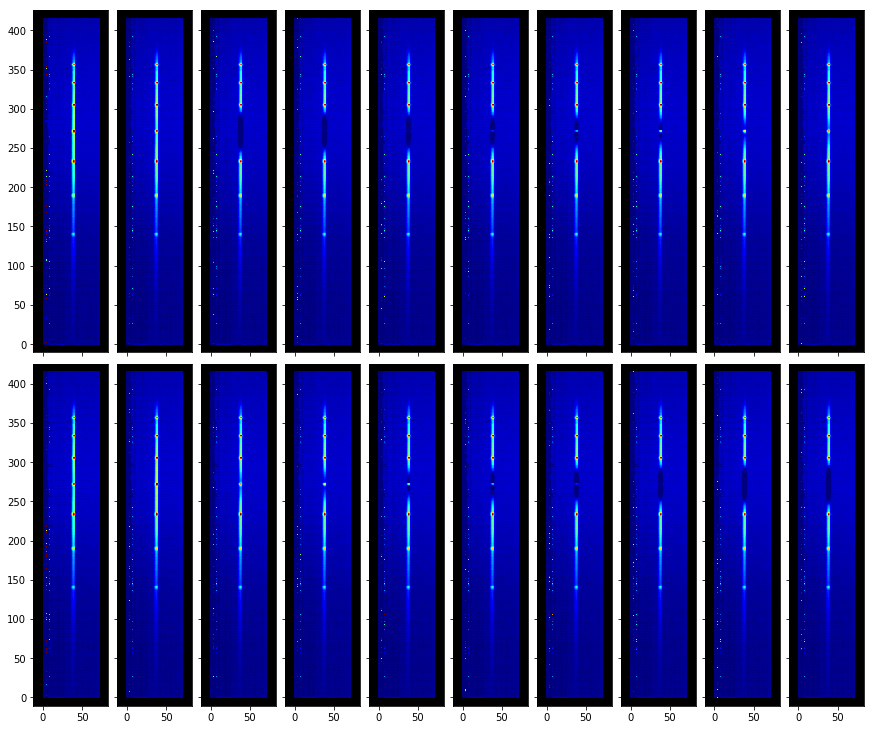

In [4]:
fig, axs = plt.subplots(2, 10, figsize=(12, 10), sharey=True, sharex=True)
axs = axs.ravel()

with datamodels.open(input_files[0]) as in_dm:
    for n in range(20):
        axs[n].imshow(in_dm.data[n,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.1e4))
        axs[n].set_facecolor('black')

plt.tight_layout(pad=0.2)
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files with slopes-per-integration will be saved in the output_dir as '*_rateints.fits'.

As described above, we manually set the array name to what the pipeline expects, ie.:

dm.meta.subarray.name = 'SUBPRISM'

The JCCWG has determined that several steps in the calwebb_detector1 pipeline should not be applied to exposures from Time-Series Observations (TSO). At this time, the steps to be skipped for MIRI TSO exposures are:

ipc
lastframe


In [6]:
# set the subarray name here
for f in input_files:
    dm = datamodels.open(f)
    dm.meta.subarray.name = 'SUBPRISM'
    dm_2A = Detector1Pipeline.call(dm, save_results=True, output_dir=output_dir, steps={'ipc':{'skip':True},
                                                                                        'lastframe':{'skip':True}})


2017-12-12 12:46:49,021 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2017-12-12 12:46:49,022 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2017-12-12 12:46:49,024 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2017-12-12 12:46:49,025 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2017-12-12 12:46:49,026 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2017-12-12 12:46:49,028 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2017-12-12 12:46:49,029 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-12 12:46:49,031 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-12 12:46:49,033 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-12 12:46:49,035 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-12 12

2017-12-12 12:47:15,498 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2017-12-12 12:47:15,800 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2017-12-12 12:47:15,977 - stpipe.Detector1Pipeline.refpix - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-12-12 12:47:16,099 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<jwst.datamodels.ramp.RampModel object at 0x11b473588>,).
2017-12-12 12:47:16,129 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2017-12-12 12:47:16,130 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2017-12-12 12:47:16,131 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-12 12:47:16,132 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-12 12:47:16,133 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-12 12:47:16,225 - stpipe.Detector1Pipeline.re

2017-12-12 12:47:31,981 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2017-12-12 12:47:31,983 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2017-12-12 12:47:31,985 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-12 12:47:31,987 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-12 12:47:31,988 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-12 12:47:31,990 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-12 12:47:31,992 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-12-12 12:47:31,994 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2017-12-12 12:47:31,996 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2017-12-12 12:47:31,998 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2017-12-12 

2017-12-12 12:47:57,010 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2017-12-12 12:47:57,011 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2017-12-12 12:47:57,012 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-12 12:47:57,013 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-12 12:47:57,014 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-12 12:47:57,092 - stpipe.Detector1Pipeline.refpix - INFO - Reference pixel correction disabled for subarray exposures
2017-12-12 12:47:57,186 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2017-12-12 12:47:57,389 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 12:47:57,390 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/referenc

2017-12-12 12:48:12,491 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-12 12:48:12,493 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-12-12 12:48:12,495 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2017-12-12 12:48:12,496 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2017-12-12 12:48:12,498 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2017-12-12 12:48:12,500 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2017-12-12 12:48:12,723 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0048.fits'.
2017-12-12 12:48:12,724 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 12:48:12,725 - stpip

2017-12-12 12:48:37,277 - stpipe.Detector1Pipeline.refpix - INFO - Reference pixel correction disabled for subarray exposures
2017-12-12 12:48:37,373 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2017-12-12 12:48:37,574 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 12:48:37,575 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0039.fits'.
2017-12-12 12:48:37,661 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<jwst.datamodels.ramp.RampModel object at 0x11b364ef0>,).
2017-12-12 12:48:37,685 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2017-12-12 12:48:37,764 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_ga

#### Quick check of the pipeline steps applied in the output:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rateints.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: None
dark_current: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


#### run pipeline
We pass each of the 'rateints.fits' files to the Spec2Pipeline and the outputs are saved in the 'calints.fits' files. We will also save the spectra extracted from each integration for each exposure ('x1dints.fits files).

In [9]:
for f in level2A_files:
    Spec2Pipeline.call(f, save_results=True, output_dir=output_dir, steps={'extract_1d':{'save_results':True}})


2017-12-12 12:48:52,617 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2017-12-12 12:48:52,619 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-12-12 12:48:52,621 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-12-12 12:48:52,622 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2017-12-12 12:48:52,624 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2017-12-12 12:48:52,625 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2017-12-12 12:48:52,627 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2017-12-12 12:48:52,628 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2017-12-12 12:48:52,629 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-12-12 12:48:52,631 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2017-12-12 12:48:5

2017-12-12 12:48:55,679 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-12-12 12:48:55,680 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-12-12 12:48:55,681 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for FLAT reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_flat_0245.fits'.
2017-12-12 12:48:55,682 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for SFLAT reference file is 'N/A'.
2017-12-12 12:48:55,767 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<jwst.datamodels.cube.CubeModel object at 0x125169da0>,).
2017-12-12 12:48:55,926 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-12-12 12:48:55,927 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2017-12-12 12:48:59,989 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2017-12-12 12:48:59,990 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-12-12 12:48:59,992 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2017-12-12 12:48:59,993 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2017-12-12 12:48:59,994 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2017-12-12 12:48:59,996 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2017-12-12 12:48:59,997 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2017-12-12 12:49:00,000 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2017-12-12 12:49:00,001 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2017-12-12 12:49:00,314 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2017-12-12 12:49:00,315

2017-12-12 12:49:03,285 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-12-12 12:49:03,285 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2017-12-12 12:49:03,286 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2017-12-12 12:49:03,287 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2017-12-12 12:49:03,357 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2017-12-12 12:49:03,460 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<jwst.datamodels.cube.CubeModel object at 0x125215080>,).
2017-12-12 12:49:03,492 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-SLITLESS
2017-12-12 12:4

2017-12-12 12:49:07,320 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2017-12-12 12:49:07,321 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2017-12-12 12:49:07,631 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2017-12-12 12:49:07,631 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2017-12-12 12:49:07,632 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-12-12 12:49:07,633 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-12-12 12:49:07,633 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2017-12-12 12:49:07,634 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-12-12 12:49:07,635 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-12-12 12:49:07,635 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION referen

2017-12-12 12:49:11,214 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2017-12-12 12:49:11,313 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<jwst.datamodels.cube.CubeModel object at 0x10d7927b8>,).
2017-12-12 12:49:11,343 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-SLITLESS
2017-12-12 12:49:11,344 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYPE is unknown. Setting to default value of POINT
2017-12-12 12:49:11,360 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2017-12-12 12:49:11,597 - stpipe.Spec2Pipeline.photom - INFO - Prefetch for AREA reference file is 'N/A'.
2017-12-12 12:49:11,598 - stpipe.Spec2Pipeline.photom - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits'.
2017-12-12 12:49:11,688 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<jwst.datamodels.cube.CubeModel object at 0x11ae8e710>,).
2017-12-

### check of output

We can have a look at the steps applied to the files in the level 2B pipeline

In [10]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_calints.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
photom: COMPLETE


While the photom step attaches the SRF to the _calints.fits files, it does not actually apply it so we must manually convert the extracted spectrum from DN/s to Jy using the SRF. We can look at the SRF while is located in the 'relsens' object in the metadata.

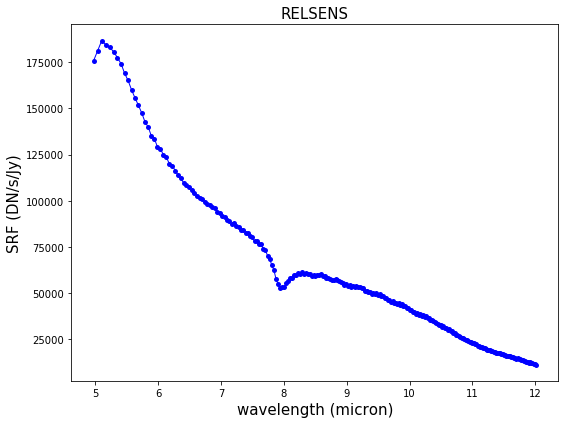

In [11]:
with datamodels.open(level2B_files[0]) as dm:  
    #print(dm.relsens)
    relsens = np.array(dm.relsens, dtype=[('wavelength', 'f4'), ('response', 'i8')])
    # plot--------------------------------------
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))

    # plot input and output ramps of the first integration
    axs.plot(relsens['wavelength'], relsens['response'], c='b', marker='o', markersize=2, 
             markeredgewidth=3, linestyle='-', linewidth=1, label='relsens')
    axs.set_title('RELSENS', fontsize=15)
    axs.set_xlabel('wavelength (micron)', fontsize=15)
    axs.set_ylabel('SRF (DN/s/Jy)', fontsize=15)

    plt.tight_layout(h_pad=0)
    plt.show()

#### plot the spectra extracted from the integrations
Using the SRF, we can flux calibrate and plot the extracted spectra

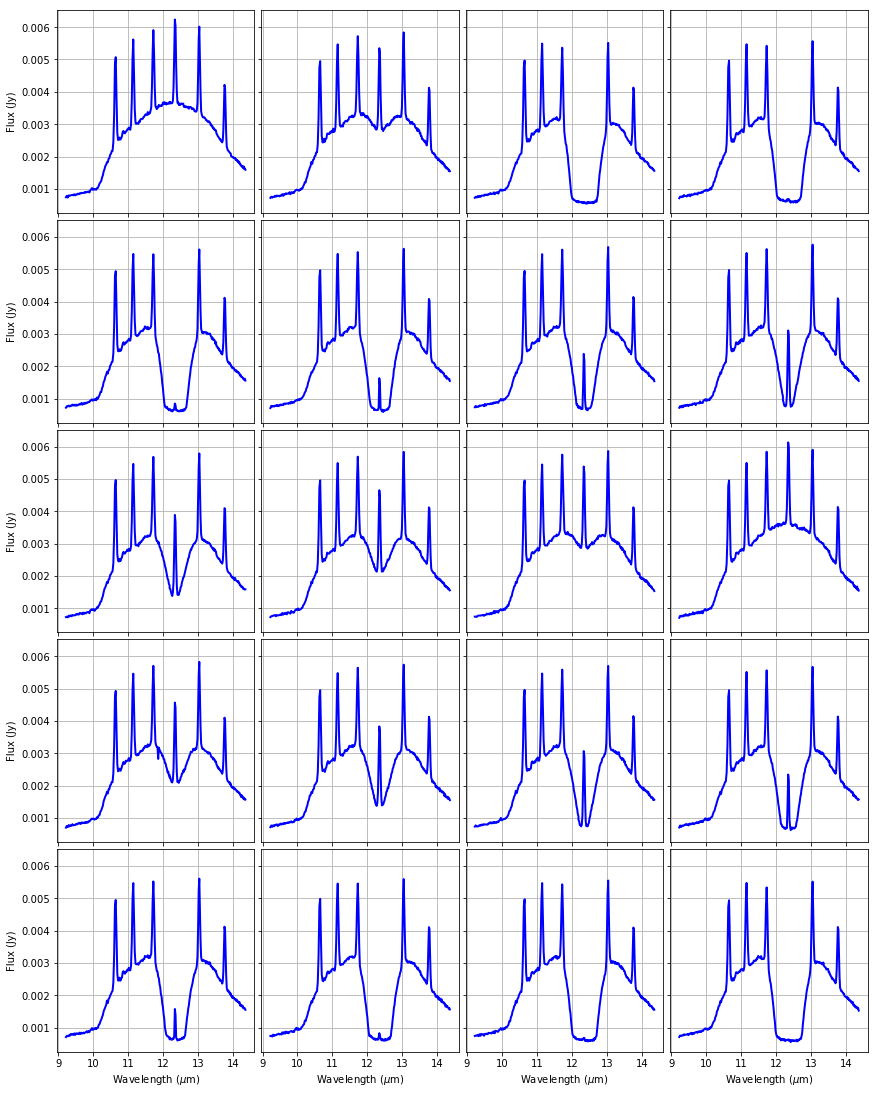

In [12]:
spec_files = glob.glob(os.path.join(output_dir,"*x1dints.fits"))
dm = datamodels.open(spec_files[0])

fig, axs = plt.subplots(5, 4, figsize=(12, 15), sharey=True, sharex=True)
axs = axs.ravel()

for n in range(20):

    # convert the flux
    response_at_data = np.interp(dm.spec[n].spec_table['WAVELENGTH'][1:-1], relsens['wavelength'], relsens['response'])
    flux_Jy = dm.spec[n].spec_table['FLUX'][1:-1] / response_at_data
    
    # plot the spectrum 
    axs[n].plot(dm.spec[n].spec_table['WAVELENGTH'][1:-1], flux_Jy, c='b', marker='.', 
             markersize=0, linestyle='-', linewidth=2)
    axs[n].grid()
    
    if n in [0, 4, 8, 12, 16]: axs[n].set_ylabel(r'Flux (Jy)')
    if n in [16, 17 , 18, 19]: axs[n].set_xlabel(r'Wavelength ($\mu$m)')

plt.tight_layout(pad=0.0)
plt.show()

### Level 3 TSO pipeline

The Tso3Pipeline requires an association as input. Therefore, we generate a level 3 association file containing the three calints files:

In [13]:
call(["asn_from_list", "-o", "LRS-SLITLESS_asn.json"] + level2B_files + ["--product-name", "tso"])

0

#### import the level 3 TSO pipeline class and print description

In [14]:
from jwst.pipeline import Tso3Pipeline
print(Tso3Pipeline.__doc__)


    TSO3Pipeline: Applies level 3 processing to TSO-mode data from
                    any JWST instrument.

    Included steps are:
        outlier_detection
        tso_photometry
        extract_1d
        white_light
    


#### run pipeline

In [15]:
Tso3Pipeline.call('LRS-SLITLESS_asn.json', output_dir=output_dir)

2017-12-12 12:49:20,829 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.
2017-12-12 12:49:20,832 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2017-12-12 12:49:20,833 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.
2017-12-12 12:49:20,835 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2017-12-12 12:49:20,836 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.
2017-12-12 12:49:21,251 - stpipe.Tso3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0004.json'.
2017-12-12 12:49:21,252 - stpipe.Tso3Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-12-12 12:49:21,253 - stpipe.Tso3Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/refere

2017-12-12 12:49:44,663 - stpipe.Tso3Pipeline.white_light - INFO - Step white_light done
2017-12-12 12:49:44,664 - stpipe.Tso3Pipeline - INFO - Extracting 1-D spectra...
2017-12-12 12:49:44,945 - stpipe.Tso3Pipeline.extract_1d - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0004.json'.
2017-12-12 12:49:45,068 - stpipe.Tso3Pipeline.extract_1d - INFO - Step extract_1d running with args (<jwst.datamodels.cube.CubeModel object at 0x1281f6630>,).
2017-12-12 12:49:45,235 - stpipe.Tso3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0004.json
2017-12-12 12:49:45,257 - stpipe.Tso3Pipeline.extract_1d - WARNING - spectral_order is None; using 1
2017-12-12 12:49:45,286 - stpipe.Tso3Pipeline.extract_1d - WARNING - Using RELSENS, 265 elements were extrapolated; these values will be set to 1.
2017-12-12 12:49:45,368 - stpipe.Tso3Pipelin

2017-12-12 12:49:53,376 - stpipe.Tso3Pipeline.white_light - INFO - Step white_light done
2017-12-12 12:49:53,378 - stpipe.Tso3Pipeline - INFO - Step.save_model LRS-SLITLESS_demo_data_pipelined/tso_x1dints.fits
2017-12-12 12:49:54,915 - stpipe.Tso3Pipeline - INFO - Writing Level 3 photometry catalog tso_whtlt.ecsv...
2017-12-12 12:49:54,919 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline done


In [16]:
# some files are not written to ouput_dir so we manually move them here
shutil.move('tso_whtlt.ecsv',os.path.join(output_dir,'tso_whtlt.ecsv'))

'LRS-SLITLESS_demo_data_pipelined/tso_whtlt.ecsv'

#### plot the spectra from all integrations in the combined x1dints file
Again, using the SRF, we can flux calibrate and plot the extracted spectra

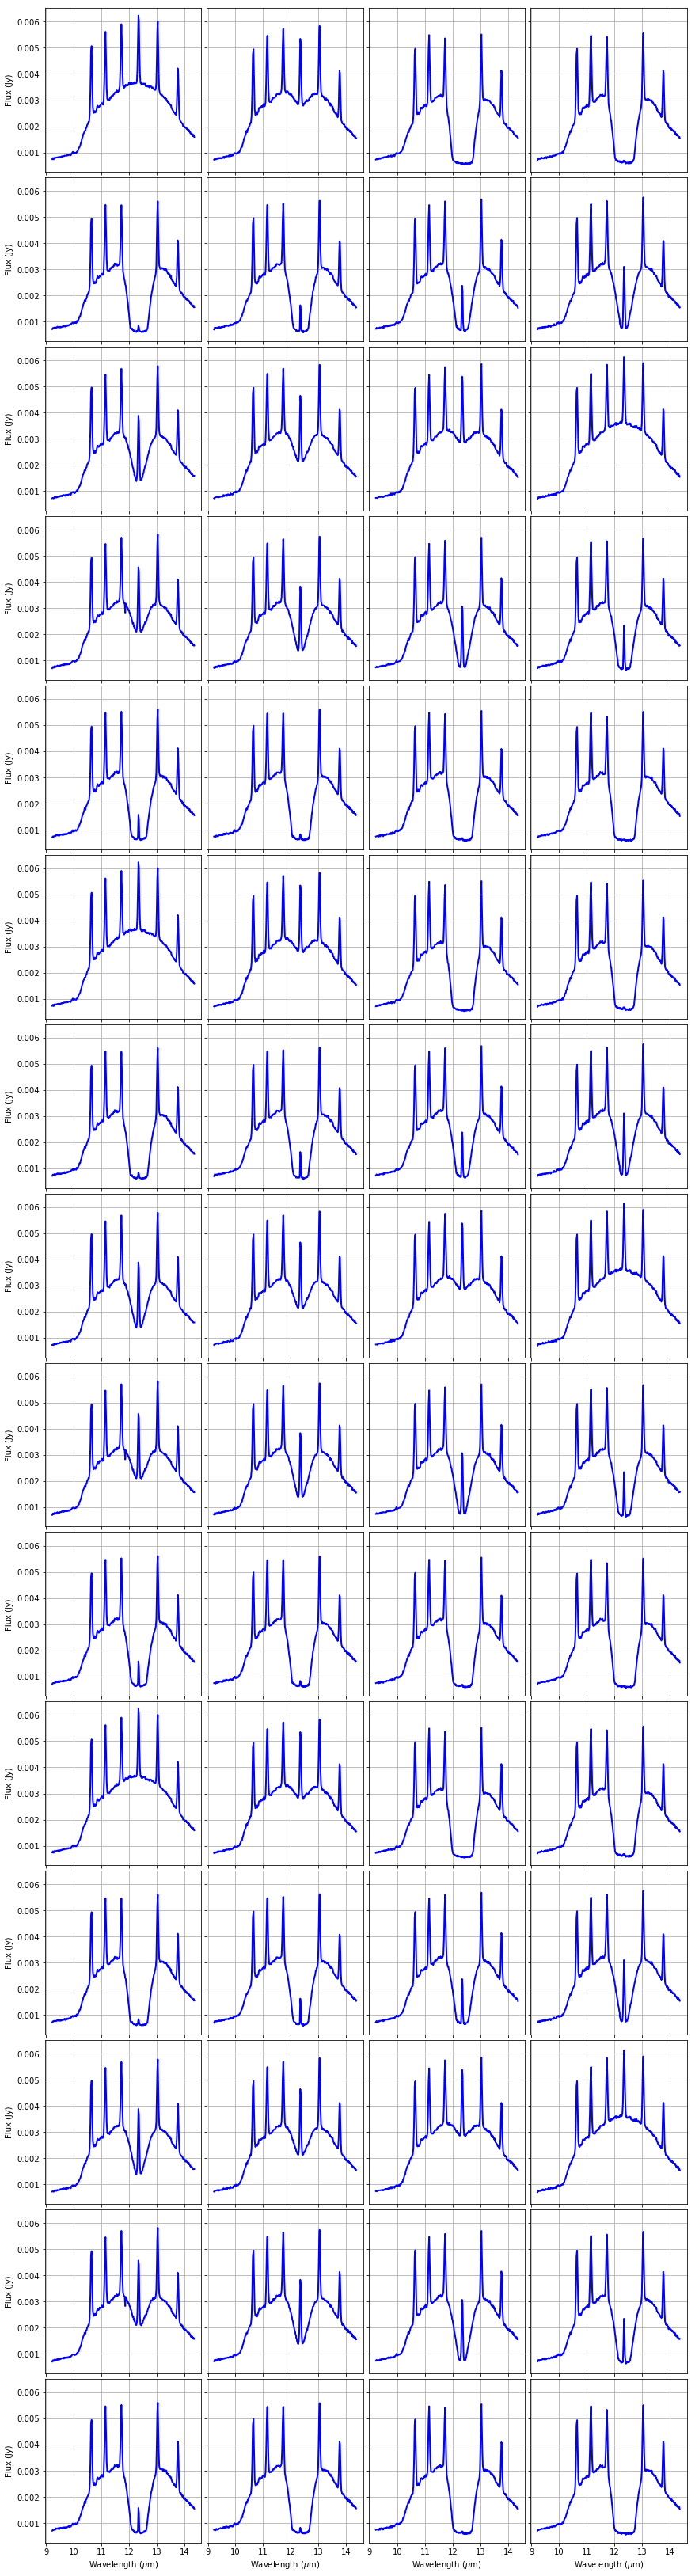

In [17]:
spec_file = glob.glob(os.path.join(output_dir,"tso_x1dints.fits"))[0]
dm = datamodels.open(spec_file)

fig, axs = plt.subplots(15, 4, figsize=(12, 45), sharey=True, sharex=True)
axs = axs.ravel()

for n in range(60):

    # convert the flux
    response_at_data = np.interp(dm.spec[n].spec_table['WAVELENGTH'][1:-1], relsens['wavelength'], relsens['response'])
    flux_phot = dm.spec[n].spec_table['FLUX'][1:-1] / response_at_data
    
    # plot the spectrum 
    axs[n].plot(dm.spec[n].spec_table['WAVELENGTH'][1:-1], flux_phot, c='b', marker='.', 
             markersize=0, linestyle='-', linewidth=2)
    axs[n].grid()
    
    if n in [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56]: axs[n].set_ylabel(r'Flux (Jy)')
    if n in [56, 57 , 58, 59]: axs[n].set_xlabel(r'Wavelength ($\mu$m)')

plt.tight_layout(pad=0.0)
plt.show()

#### look at the white-light photometry lightcurve

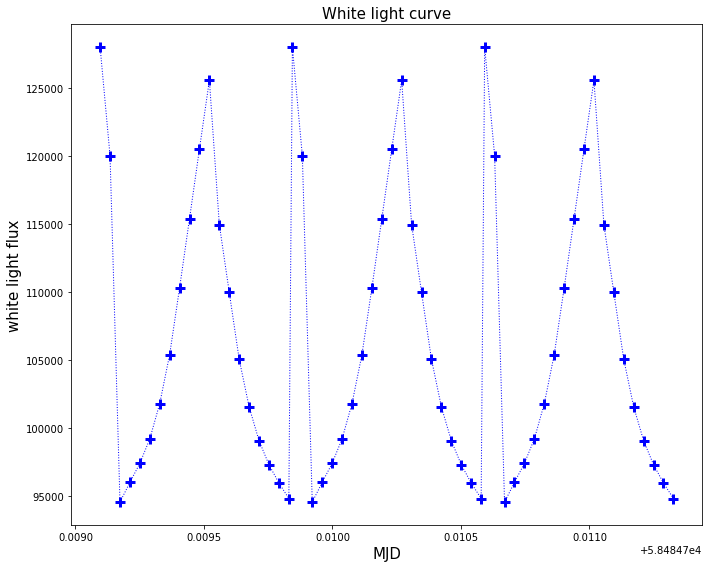

In [18]:
from astropy.table import Table

my_lightcurve = os.path.join(output_dir,'tso_whtlt.ecsv')
lightcurve_data = Table.read(my_lightcurve, format='ascii.ecsv')

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# plot input and output ramps of the first integration
axs.plot(lightcurve_data['MJD'], lightcurve_data['whitelight_flux'], c='b', marker='+', markersize=10, 
         markeredgewidth=3, linestyle=':', linewidth=1, label='white light curve')
axs.set_title('White light curve', fontsize=15)
axs.set_ylabel('white light flux', fontsize=15)
axs.set_xlabel('MJD', fontsize=15)

plt.tight_layout(h_pad=0)
plt.show()